In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from torchsummary import summary
from torchvision import datasets, transforms
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

In [77]:
#check if you can speed up learning with gpu cuda cores. else, just use the cpu
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")
print(device)

cpu


In [78]:
torch.manual_seed(42)

In [79]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("muratkokludataset/pistachio-image-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\mccor\.cache\kagglehub\datasets\muratkokludataset\pistachio-image-dataset\versions\1


### Outlining my approach to this project
- I'm going to use a CNN with a stride of 1 because the dataset isn't too large and all the images are JPG. No point in wasting information on smaller photo sizes
- This will only require a shallow CNN. I will use a 70/15/15 training/test/validation split due to the smaller size of the dataset as well. In a project with big data, such as the GeoSpatial Forest Fire Prediction project (I would assume it uses a massive dataset), a 98/1/1 split is more standard.
- Because I am making a classifcation model, I will BCE Loss with Logits. If the model predicts 1, I will return true for the species being Kirmizi. Otherwise, I will return that the image is a Siirt Pistachio. If there were more species or possibly non-pistachio images, I would have used a softmax output activation function instead for the output or used argmax with logits and had an output vector the size of the num of classes.
- The dataset appears clean, with no null values, and everything is already labeled. Therefore, it is a simple choice to just use supervised learning techniques, and I shouldn't need to feature engineer much. The biggest priority will just be rescaling the input data to a more normal distribution, which I will do using transforms. Normalize from PyTorch, setting it to ML algorithm-friendly values. Also, data augmentation via adding cropping or fuzziness to images can help add extra data to the dataset too

In [80]:
# Path to images, for both Kirmizi and Siirt
from pathlib import Path
images_path = Path(path) / "Pistachio_Image_Dataset" / "Pistachio_Image_Dataset"
kirm_path =  Path(path) / "Pistachio_Image_Dataset" / "Pistachio_Image_Dataset" / "Kirmizi_Pistachio"
siirt_path =  Path(path) / "Pistachio_Image_Dataset" / "Pistachio_Image_Dataset" / "Siirt_Pistachio"

print(images_path, "\n", kirm_path, "\n", siirt_path)

C:\Users\mccor\.cache\kagglehub\datasets\muratkokludataset\pistachio-image-dataset\versions\1\Pistachio_Image_Dataset\Pistachio_Image_Dataset 
 C:\Users\mccor\.cache\kagglehub\datasets\muratkokludataset\pistachio-image-dataset\versions\1\Pistachio_Image_Dataset\Pistachio_Image_Dataset\Kirmizi_Pistachio 
 C:\Users\mccor\.cache\kagglehub\datasets\muratkokludataset\pistachio-image-dataset\versions\1\Pistachio_Image_Dataset\Pistachio_Image_Dataset\Siirt_Pistachio


### Turn the two folders into a dataset via the root and ImageFolder. Normalize the image rgb values to encourage faster convergence

In [81]:
# Transformation Pipeline. Normalize. Resize to 224x224 for a nice middle ground between fast training and high quality data
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
])

In [82]:
dataset = datasets.ImageFolder(images_path, transform=transform)

In [83]:
print(dataset.classes)
print(dataset.class_to_idx)

['Kirmizi_Pistachio', 'Siirt_Pistachio']
{'Kirmizi_Pistachio': 0, 'Siirt_Pistachio': 1}


In [84]:
# Define Classes
classes = dataset.classes
classes

['Kirmizi_Pistachio', 'Siirt_Pistachio']

In [85]:
img, label = dataset[100]
print(img.shape)          
print(label)              

torch.Size([3, 128, 128])
0


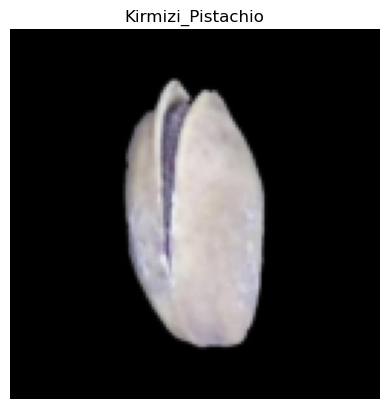

In [86]:

mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

denorm = transforms.Normalize(
    mean=[-m/s for m, s in zip(mean, std)],
    std=[1/s for s in std]
)

img, label = dataset[0]
# [3, H, W], normalized -> [H, W, 3], unnormalized
img_disp = denorm(img).permute(1, 2, 0)
plt.imshow(img_disp)
plt.title(dataset.classes[label])
plt.axis("off")
plt.show()

## Separate Data into val/Train/Validation sets

In [87]:
num_total = len(dataset)
train_num = int(0.7 * num_total)
val_num   = int(0.15 * num_total)
test_num  = num_total - train_num - val_num

torch.manual_seed(42)
train_ds, val_ds, test_ds = torch.utils.data.random_split(dataset, [train_num, val_num, test_num])
len(train_ds) , len(val_ds), len(test_ds)

(1503, 322, 323)

## Making the CNN Model
- Smaller dataset,keeping stride at 1 so I get as much info as possible from each picture
- Padding=1 to maintain size of images across NN layers

In [88]:
class PistachioCNN(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels = input_shape,
                      out_channels = hidden_units,
                      kernel_size = 3,
                      stride = 1,
                      padding = 1
                     ),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels = hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1
                     ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels = hidden_units,
                      out_channels = hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1
                     ),
            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_units,
                      out_channels = hidden_units,
                      kernel_size = 3,
                      stride = 1,
                      padding = 1
                     ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features= 32 * 32 * hidden_units,
                      out_features=output_shape)
        )
    def forward(self, x):
        x = self.conv_block1(x)
        #print(x.shape)
        x = self.conv_block2(x)
        #print(x.shape)
        x = self.classifier(x)
        return x
            

In [89]:
# get model layer sizes
input_tensor = torch.randn(3, 128, 128)
pistachio_model = PistachioCNN(input_shape=3, hidden_units=10, output_shape=1).to(device)
pistachio_model(input_tensor.unsqueeze(0)).to(device)

tensor([[-0.0128]], grad_fn=<AddmmBackward0>)

## classification layer in_features size
- needs to be 10 *32 * 32 because the convolutional nn blocks reduce the images down to 32x32, and there are 10 hidden units in each block
- results in a [1, 10240] sized block after they get flattened down

In [90]:
# set the seed to 42 because for some reason every single ML course I used over the summer to learn ML loved 42 since it's
# the answer to the universe in a famous book.
torch.manual_seed(42)

In [91]:
# loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(pistachio_model.parameters(), lr = 0.001)

# Making Data Loaders for Mini-Batching
- Not as necessary for this smaller dataset, although I want to show I understand the concept of mini-batching for big data projects.

In [92]:
# make Data Loaders for mini-batch training.
from torch.utils.data import DataLoader
# setup batch size hyperparameter
BATCH_SIZE = 16

# Turn datasets into iterables
train_dataloader = DataLoader(dataset=train_ds,
                              batch_size=BATCH_SIZE,
                              shuffle=True)
val_dataloader = DataLoader(dataset=val_ds,
                             batch_size = BATCH_SIZE,
                             shuffle=False)
test_dataloader = DataLoader(dataset=test_ds,
                             batch_size = BATCH_SIZE,
                             shuffle=False)
train_dataloader, val_dataloader,test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x25f8eaf9d50>,
 <torch.utils.data.dataloader.DataLoader at 0x25f8c5c0650>)

In [93]:
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of val dataloader: {len(val_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Length of train dataloader: 94 batches of 16
Length of val dataloader: 21 batches of 16
Length of test dataloader: 21 batches of 16


In [94]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([16, 3, 128, 128]), torch.Size([16]))

(Text(0.5, 1.0, 'Kirmizi_Pistachio'),
 tensor(0),
 {'Kirmizi_Pistachio': 0, 'Siirt_Pistachio': 1})

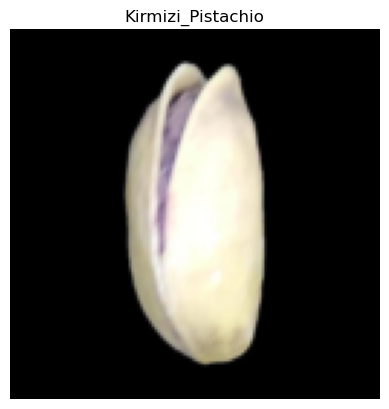

In [95]:
# Show a sample
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
image, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(denorm(image).permute(1, 2, 0))
plt.axis(False)
plt.title(classes[label]), label, dataset.class_to_idx

In [96]:
# Making an accuracy, precision, and recall function
from torchmetrics.functional import accuracy, precision, recall
def metrics_fn(preds, target, threshold=0.5):
    preds  = preds.squeeze()
    target = target.long()
    acc  = accuracy(preds, target, task="binary", threshold=threshold)
    prec = precision(preds, target, task="binary", threshold=threshold, average="micro")
    rec  = recall(preds, target, task="binary", threshold=threshold, average="micro")
    return acc, prec, rec

In [97]:
def accuracy_fn(y_true, y_pred):
    
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

### Make validation and training steps

In [98]:
from torchmetrics.functional import accuracy

def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               metrics,
               device: torch.device = device,
               loss_tracker: list[float] = [],
               acc_tracker: list[float] = []):
  ''' performs training step with inputted model '''
  ### Training
  train_loss, train_acc = 0, 0
  # Add a loop to loop through the training batches
  for batch, (X, y) in enumerate(data_loader):
    model.train()

    # Put data on target device
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_logits = model(X).squeeze()
    #y_logits = y_logits.squeeze(1)
    y_preds = torch.round(torch.sigmoid(y_logits))
    # 2. Calculate loss (per batch)
    loss = loss_fn(y_logits, y.float())
    train_loss += loss # accumulate train loss
    train_acc += accuracy(y_preds, y.long(), task="binary", threshold=0.5)
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Print out what's happening:
    if batch % 10 == 0:
      print(f"Looked at {batch * len(X)} items, {(batch * len(X)/len(train_dataloader.dataset) * 100):.3f}% of samples seen")

  # Divide total train loss by length of train dataloader
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  loss_tracker.append(train_loss.cpu().detach().numpy())
  acc_tracker.append(train_acc.cpu().detach().numpy())
  print(f"\nTrain loss:{train_loss:.3f} | Train Acc:{train_acc*100:.3f}%")


In [99]:

def val_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               metrics,
               device: torch.device = device,
               loss_tracker: list[float] = [],
               acc_tracker: list[float] = []):
  val_loss, val_acc, val_precision, val_recall = 0, 0, 0, 0
  model.eval()
  with torch.inference_mode():
    for X_val, y_val in data_loader:
      # Put data on target device
      X_val, y_val = X_val.to(device), y_val.to(device)
      #1. Forward Pass
      val_logits = model(X_val)
      val_logits = val_logits.squeeze(1)
      val_preds = torch.round(torch.sigmoid(val_logits))
      # 2. Calculate Loss
      val_loss += loss_fn(val_logits, y_val.float())
      # 3. calculate metrics
      acc, prec, rec = metrics(preds=val_preds, target=y_val)
      val_acc += acc
      val_precision += prec
      val_recall += rec

    # Calculate the validation loss average per batch
    val_loss /= len(data_loader)
    loss_tracker.append(val_loss.cpu().detach().numpy())
    # Calculate the validation metrics per batch
    val_acc /= len(data_loader)
    val_precision /= len(data_loader)
    val_recall /= len(data_loader)
    acc_tracker.append(val_acc.cpu().detach().numpy())

  # Print out what's happening
  print(f"\nValidation loss: {val_loss:.3f} | Validation Acc:{val_acc*100:.3f}% | Validation Precision:{val_precision*100:.3f}% | Validation Recall:{val_recall*100:.3f}%")

# Training! 
- Make training and test functions, then loop through a few epochs

In [100]:
from tqdm.auto import tqdm
from timeit import default_timer as timer
#Set the seed, start the timer
torch.manual_seed(42)
start_time = timer()
metrics_fn = metrics_fn
# Set the number of epochs
epochs = 10
train_loss_tracker = []
val_loss_tracker = []
train_acc_tracker = []
val_acc_tracker = []
# Create training and test loop
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n-------")
  # Training Step
  train_step(model=pistachio_model,
             data_loader= train_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             metrics=metrics_fn,
             device=device,
             loss_tracker=train_loss_tracker,
             acc_tracker=train_acc_tracker)

  # Validation Step
  val_step(model=pistachio_model,
             data_loader= val_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             metrics=metrics_fn,
             device=device,
             loss_tracker=val_loss_tracker,
             acc_tracker=val_acc_tracker)

# Calculate training time:
end_time = timer()
print(f"Training time for {epochs} epochs: {end_time - start_time:.3f} seconds")
train_loss_tracker, val_loss_tracker, train_acc_tracker, val_acc_tracker

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0 items, 0.000% of samples seen
Looked at 160 items, 10.645% of samples seen
Looked at 320 items, 21.291% of samples seen
Looked at 480 items, 31.936% of samples seen
Looked at 640 items, 42.582% of samples seen
Looked at 800 items, 53.227% of samples seen
Looked at 960 items, 63.872% of samples seen
Looked at 1120 items, 74.518% of samples seen
Looked at 1280 items, 85.163% of samples seen
Looked at 1440 items, 95.808% of samples seen

Train loss:0.465 | Train Acc:78.378%

Validation loss: 0.348 | Validation Acc:83.036% | Validation Precision:84.358% | Validation Recall:69.497%
Epoch: 1
-------
Looked at 0 items, 0.000% of samples seen
Looked at 160 items, 10.645% of samples seen
Looked at 320 items, 21.291% of samples seen
Looked at 480 items, 31.936% of samples seen
Looked at 640 items, 42.582% of samples seen
Looked at 800 items, 53.227% of samples seen
Looked at 960 items, 63.872% of samples seen
Looked at 1120 items, 74.518% of samples seen
Looked at 12

([array(0.46487054, dtype=float32),
  array(0.34344268, dtype=float32),
  array(0.30610138, dtype=float32),
  array(0.301332, dtype=float32),
  array(0.2658344, dtype=float32),
  array(0.25181565, dtype=float32),
  array(0.23793057, dtype=float32),
  array(0.22705624, dtype=float32),
  array(0.21973462, dtype=float32),
  array(0.19563696, dtype=float32)],
 [array(0.34778312, dtype=float32),
  array(0.42672208, dtype=float32),
  array(0.34583116, dtype=float32),
  array(0.37759903, dtype=float32),
  array(0.32865462, dtype=float32),
  array(0.37838113, dtype=float32),
  array(0.36821258, dtype=float32),
  array(0.46904773, dtype=float32),
  array(0.35300013, dtype=float32),
  array(0.4640661, dtype=float32)],
 [array(0.78377664, dtype=float32),
  array(0.8461436, dtype=float32),
  array(0.86702126, dtype=float32),
  array(0.86684394, dtype=float32),
  array(0.89024824, dtype=float32),
  array(0.89880323, dtype=float32),
  array(0.9007535, dtype=float32),
  array(0.9101507, dtype=float32

In [101]:
train_acc_tracker, val_acc_tracker

([array(0.78377664, dtype=float32),
  array(0.8461436, dtype=float32),
  array(0.86702126, dtype=float32),
  array(0.86684394, dtype=float32),
  array(0.89024824, dtype=float32),
  array(0.89880323, dtype=float32),
  array(0.9007535, dtype=float32),
  array(0.9101507, dtype=float32),
  array(0.90616137, dtype=float32),
  array(0.92278373, dtype=float32)],
 [array(0.83035713, dtype=float32),
  array(0.8005952, dtype=float32),
  array(0.84821427, dtype=float32),
  array(0.83928573, dtype=float32),
  array(0.85119045, dtype=float32),
  array(0.83630955, dtype=float32),
  array(0.85714287, dtype=float32),
  array(0.8333333, dtype=float32),
  array(0.86011904, dtype=float32),
  array(0.8244048, dtype=float32)])

### Making a lil graph for the accuracy on the training and test set after each epoch
- will determine what the correct number of epochs i could choose would be. wherever val is at its lowest loss or highest accuracy is the epoch i would choose for production

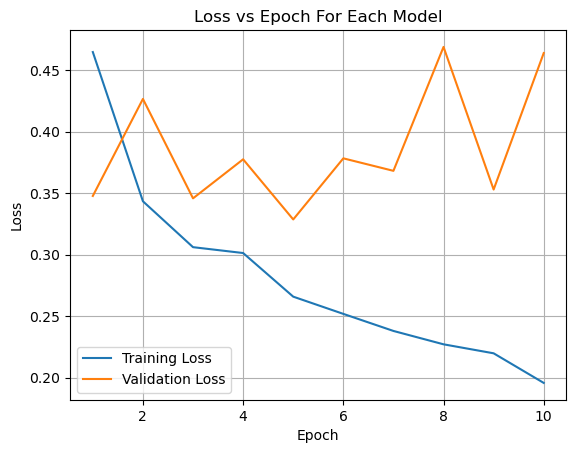

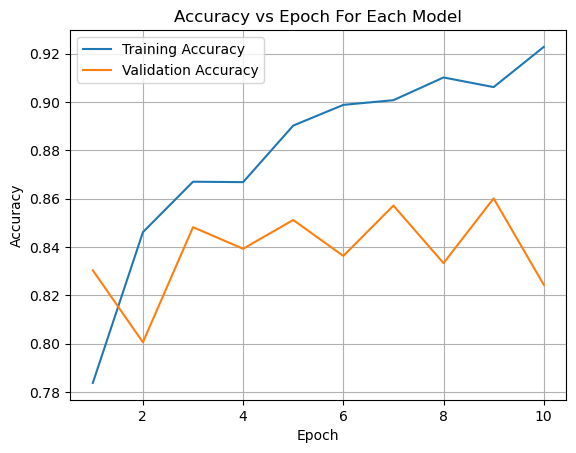

In [102]:
import numpy as np
import matplotlib.pyplot as plt

epoch_num = len(train_loss_tracker)
x = np.arange(1, epoch_num + 1)

plt.figure()
plt.plot(x, train_loss_tracker, label="Training Loss")
plt.plot(x, val_loss_tracker, label="Validation Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss vs Epoch For Each Model")
plt.legend(); plt.grid(True); plt.show()

plt.figure()
plt.plot(x, train_acc_tracker, label="Training Accuracy")
plt.plot(x, val_acc_tracker, label="Validation Accuracy")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Accuracy vs Epoch For Each Model")
plt.legend(); plt.grid(True); plt.show()

# Make Evaluation Model Function for Making Model Comparisons

In [103]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              metrics,
              device: torch.device = device): # added device parameter
  ''' Returns a dict containing the resutls of model predicting on data_loader '''
  test_loss, test_acc, test_precision, test_recall = 0, 0, 0, 0
  model.eval()
  with torch.inference_mode():
    for X_val, y_val in data_loader:
      # Put data on target device
      X_val, y_val = X_val.to(device), y_val.to(device)
      #1. Forward Pass
      test_logits = model(X_val)
      test_logits = test_logits.squeeze(1)
      test_preds = torch.sigmoid(test_logits)
      # 2. Calculate Loss
      test_loss += loss_fn(test_logits, y_val.float())
      # Get metrics
      acc, prec, rec = metrics(preds=test_preds, target=y_val.long())
      test_acc += acc
      test_precision += prec
      test_recall += rec

    # Scale loss and acc to find the average loss/acc per batch
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    test_precision /= len(data_loader)
    test_recall /= len(data_loader)
  return {"model_name": model.__class__.__name__,
          "model_loss": test_loss.item(),
          "model_acc": test_acc,
          "model_precision": test_precision,
          "model_recall": test_recall}
# Calculate model_1 results on test dataset
model1_results = eval_model(pistachio_model,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             metrics=metrics_fn,
                             device=device)
model1_results

{'model_name': 'PistachioCNN',
 'model_loss': 0.351144939661026,
 'model_acc': tensor(0.8899),
 'model_precision': tensor(0.9464),
 'model_recall': tensor(0.7730)}

### Make augmented data. train a second model on it and see how it affects performance

In [104]:
pistachio_model2 = PistachioCNN(input_shape=3, hidden_units=10, output_shape=1).to(device)

In [105]:
from torch.utils.data import ConcatDataset
from torchvision.transforms import v2
from torch.utils.data import Subset

# I love pytorch boilerplate code!
augment_transform = v2.Compose([
    v2.RandomResizedCrop(size=(128, 128), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    v2.RandomRotation(degrees=20),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# use transform from earlier for val and test data. use augmented data for training data
base_dataset = datasets.ImageFolder(images_path, transform=None)
ds_len = len(base_dataset)
g = torch.manual_seed(42)
train_idx, val_idx, test_idx = torch.utils.data.random_split(range(len(base_dataset)), [train_num, val_num, test_num], generator=g)

train_ds = torch.utils.data.Subset(datasets.ImageFolder(images_path, transform=transform), train_idx.indices)
aug_ds = torch.utils.data.Subset(datasets.ImageFolder(images_path, transform=augment_transform), train_idx.indices)
val_ds   = torch.utils.data.Subset(datasets.ImageFolder(images_path, transform=transform),  val_idx.indices)
test_ds  = torch.utils.data.Subset(datasets.ImageFolder(images_path, transform=transform),  test_idx.indices)

# concat augmented to original dataset
train_new_ds = ConcatDataset([train_ds, aug_ds])
len(train_new_ds), len(train_ds), len(aug_ds), len(val_ds), len(test_ds)
#train_aug_dataloader = DataLoader(train_new_ds, batch_size=BATCH_SIZE, shuffle=True)


c:\Users\mccor\anaconda3\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


(3006, 1503, 1503, 322, 323)

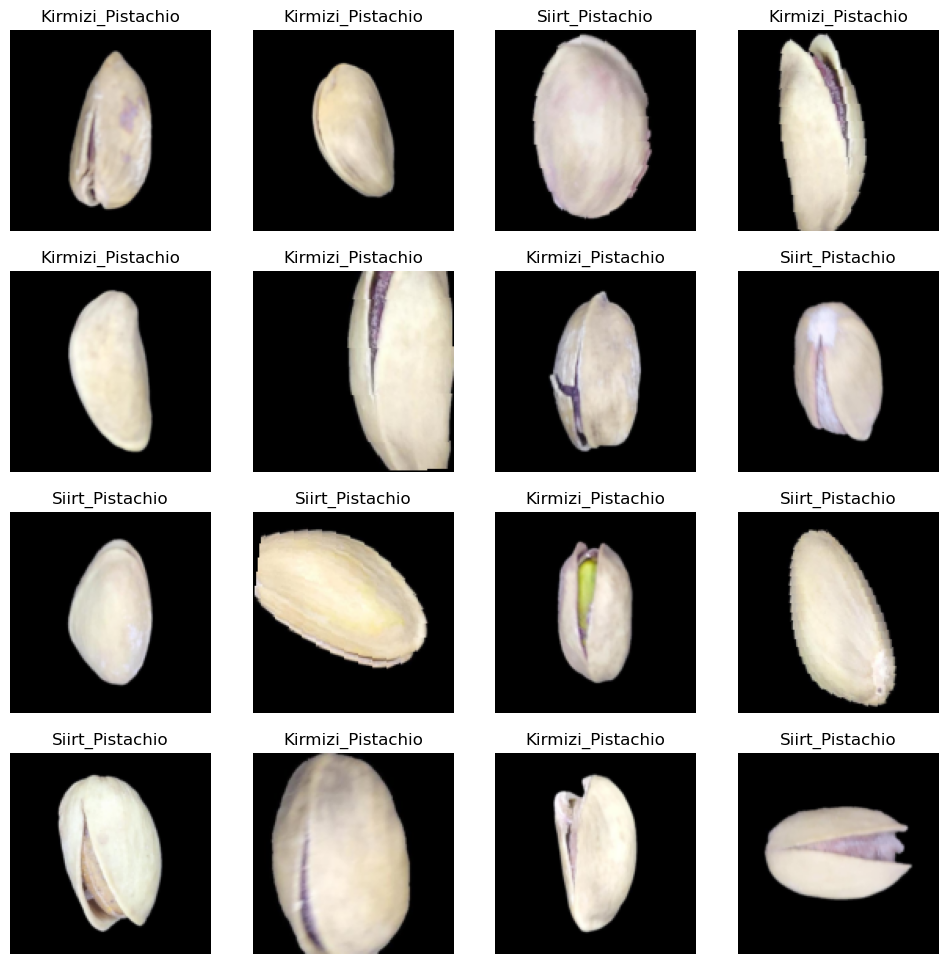

In [106]:
# Show some examples of augmented data
# Show a sample
torch.manual_seed(42)
fig = plt.figure(figsize=(12,12))
rows, cols = 4,4
for i in range (1, rows*cols+1):
    random_idx = torch.randint(0, len(train_new_ds), size=[1]).item()
    image, label = train_new_ds[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(denorm(image).permute(1, 2, 0))
    plt.axis(False)
    plt.title(classes[label]), label, dataset.class_to_idx

# Train with New Data
- I'm just gonna copy what i did earlier, with the new data now though.
Steps:
1. Make new training, val, and test dataloader, new loss function, new optimizer
2. Train new model
3. Graph new loss and accuracy graphs with train and validation models
4. Evaluate versus Test Data
4. Compare Augmented data vs Original data trained models

In [107]:
train_aug_dataloader = DataLoader(train_new_ds, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

In [108]:
optimizer2 = optim.Adam(pistachio_model2.parameters(), lr = 0.001)

In [109]:
from tqdm.auto import tqdm
from timeit import default_timer as timer
#Set the seed, start the timer
torch.manual_seed(42)
start_time = timer()
metrics_fn = metrics_fn
# Set the number of epochs
epochs = 10
train_loss_tracker = []
val_loss_tracker = []
train_acc_tracker = []
val_acc_tracker = []
# Create training and test loop
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n-------")
  # Training Step
  train_step(model=pistachio_model2,
             data_loader= train_aug_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer2,
             metrics=metrics_fn,
             device=device,
             loss_tracker=train_loss_tracker,
             acc_tracker=train_acc_tracker)

  # Validation Step
  val_step(model=pistachio_model2,
             data_loader= val_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer2,
             metrics=metrics_fn,
             device=device,
             loss_tracker=val_loss_tracker,
             acc_tracker=val_acc_tracker)

# Calculate training time:
end_time = timer()
print(f"Training time for {epochs} epochs: {end_time - start_time:.3f} seconds")
#train_loss_tracker, val_loss_tracker, train_acc_tracker, val_acc_tracker

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0 items, 0.000% of samples seen
Looked at 160 items, 10.645% of samples seen
Looked at 320 items, 21.291% of samples seen
Looked at 480 items, 31.936% of samples seen
Looked at 640 items, 42.582% of samples seen
Looked at 800 items, 53.227% of samples seen
Looked at 960 items, 63.872% of samples seen
Looked at 1120 items, 74.518% of samples seen
Looked at 1280 items, 85.163% of samples seen
Looked at 1440 items, 95.808% of samples seen
Looked at 1600 items, 106.454% of samples seen
Looked at 1760 items, 117.099% of samples seen
Looked at 1920 items, 127.745% of samples seen
Looked at 2080 items, 138.390% of samples seen
Looked at 2240 items, 149.035% of samples seen
Looked at 2400 items, 159.681% of samples seen
Looked at 2560 items, 170.326% of samples seen
Looked at 2720 items, 180.971% of samples seen
Looked at 2880 items, 191.617% of samples seen

Train loss:0.593 | Train Acc:66.432%

Validation loss: 0.450 | Validation Acc:78.869% | Validation Precision:

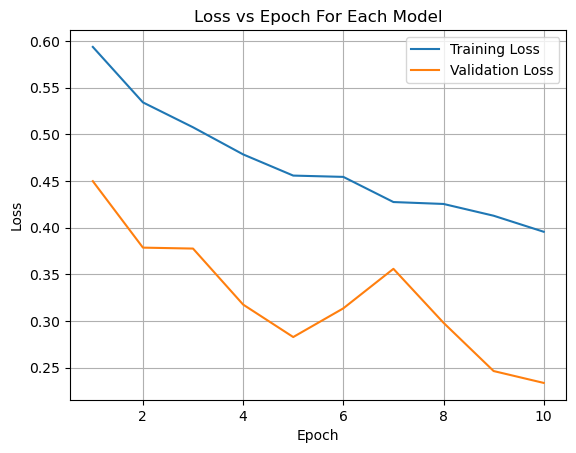

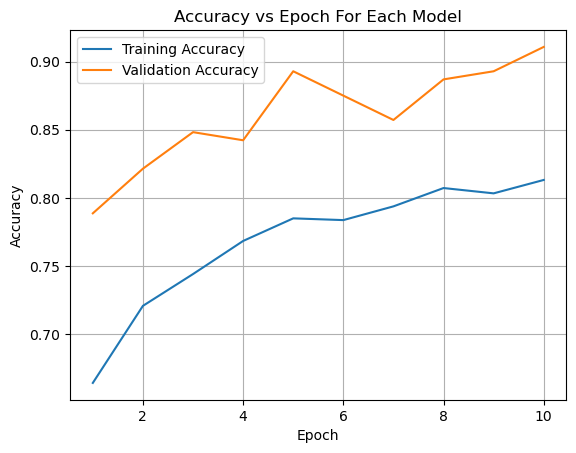

In [110]:
import numpy as np
import matplotlib.pyplot as plt

epoch_num = len(train_loss_tracker)
x = np.arange(1, epoch_num + 1)

plt.figure()
plt.plot(x, train_loss_tracker, label="Training Loss")
plt.plot(x, val_loss_tracker, label="Validation Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss vs Epoch For Each Model")
plt.legend(); plt.grid(True); plt.show()

plt.figure()
plt.plot(x, train_acc_tracker, label="Training Accuracy")
plt.plot(x, val_acc_tracker, label="Validation Accuracy")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Accuracy vs Epoch For Each Model")
plt.legend(); plt.grid(True); plt.show()

In [111]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              metrics,
              device: torch.device = device): # added device parameter
  ''' Returns a dict containing the resutls of model predicting on data_loader '''
  test_loss, test_acc, test_precision, test_recall = 0, 0, 0, 0
  model.eval()
  with torch.inference_mode():
    for X_val, y_val in data_loader:
      # Put data on target device
      X_val, y_val = X_val.to(device), y_val.to(device)
      #1. Forward Pass
      test_logits = model(X_val)
      test_logits = test_logits.squeeze(1)
      test_preds = torch.sigmoid(test_logits)
      # 2. Calculate Loss
      test_loss += loss_fn(test_logits, y_val.float())
      # Get metrics
      acc, prec, rec = metrics(preds=test_preds, target=y_val.long())
      test_acc += acc
      test_precision += prec
      test_recall += rec

    # Scale loss and acc to find the average loss/acc per batch
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    test_precision /= len(data_loader)
    test_recall /= len(data_loader)
  return {"model_name": model.__class__.__name__,
          "model_loss": test_loss.item(),
          "model_acc": test_acc,
          "model_precision": test_precision,
          "model_recall": test_recall}
# Calculate model_2 results on test dataset
model2_results = eval_model(pistachio_model2,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             metrics=metrics_fn,
                             device=device)
model2_results

{'model_name': 'PistachioCNN',
 'model_loss': 0.24131575226783752,
 'model_acc': tensor(0.9167),
 'model_precision': tensor(0.9074),
 'model_recall': tensor(0.8719)}

In [112]:
import pandas as pd
model_df = pd.DataFrame([model1_results, model2_results])
model_df

,model_name,model_loss,model_acc,model_precision,model_recall
0,PistachioCNN,0.351145,tensor(0.8899),tensor(0.9464),tensor(0.7730)
1,PistachioCNN,0.241316,tensor(0.9167),tensor(0.9074),tensor(0.8719)


## What about Drop-Out and L1 or L2 Regularization?
I could test Drop Out regularization or L1/L2 Regularization to see if that makes the variance decrease, but the training vs val vs test accuracies aren't too different from each other, so I don't think it's worth my time to experiment for this project, given that it's only an application

Also, data augmentation like I did works as a form of regularization as well, as seen by the test and validation datasets outperforming the training dataset on accuracy. This shows how augmented data can generalize quite well.

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0 items, 0.000% of samples seen
Looked at 160 items, 10.645% of samples seen
Looked at 320 items, 21.291% of samples seen
Looked at 480 items, 31.936% of samples seen
Looked at 640 items, 42.582% of samples seen
Looked at 800 items, 53.227% of samples seen
Looked at 960 items, 63.872% of samples seen
Looked at 1120 items, 74.518% of samples seen
Looked at 1280 items, 85.163% of samples seen
Looked at 1440 items, 95.808% of samples seen
Looked at 1600 items, 106.454% of samples seen
Looked at 1760 items, 117.099% of samples seen
Looked at 1920 items, 127.745% of samples seen
Looked at 2080 items, 138.390% of samples seen
Looked at 2240 items, 149.035% of samples seen
Looked at 2400 items, 159.681% of samples seen
Looked at 2560 items, 170.326% of samples seen
Looked at 2720 items, 180.971% of samples seen
Looked at 2880 items, 191.617% of samples seen

Train loss:0.388 | Train Acc:82.285%

Validation loss: 0.349 | Validation Acc:86.607% | Validation Precision:

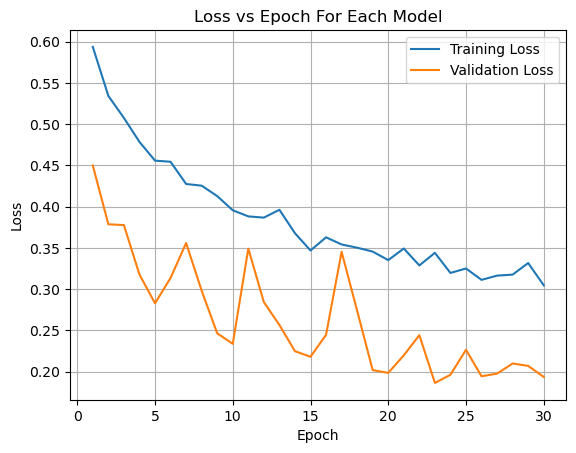

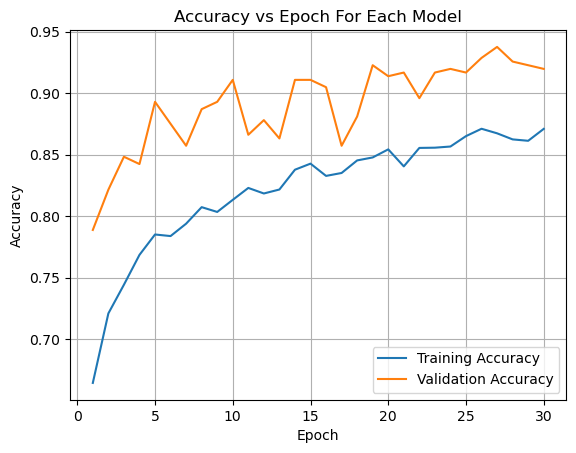

In [113]:
# I'm going to train the augmented data more to see at what epoch it starts to overfit
# here we go

from tqdm.auto import tqdm
from timeit import default_timer as timer
#Set the seed, start the timer
torch.manual_seed(42)
start_time = timer()
metrics_fn = metrics_fn
# Set the number of epochs
epochs = 20
# Create training and test loop
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n-------")
  # Training Step
  train_step(model=pistachio_model2,
             data_loader= train_aug_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer2,
             metrics=metrics_fn,
             device=device,
             loss_tracker=train_loss_tracker,
             acc_tracker=train_acc_tracker)

  # Validation Step
  val_step(model=pistachio_model2,
             data_loader= val_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer2,
             metrics=metrics_fn,
             device=device,
             loss_tracker=val_loss_tracker,
             acc_tracker=val_acc_tracker)

# Calculate training time:
end_time = timer()
print(f"Training time for {epochs} epochs: {end_time - start_time:.3f} seconds")


epoch_num = len(train_loss_tracker)
x = np.arange(1, epoch_num + 1)

plt.figure()
plt.plot(x, train_loss_tracker, label="Training Loss")
plt.plot(x, val_loss_tracker, label="Validation Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss vs Epoch For Each Model")
plt.legend(); plt.grid(True); plt.show()

plt.figure()
plt.plot(x, train_acc_tracker, label="Training Accuracy")
plt.plot(x, val_acc_tracker, label="Validation Accuracy")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Accuracy vs Epoch For Each Model")
plt.legend(); plt.grid(True); plt.show()

### Best Performing Epoch on the validation data is:
# Epoch: 30. I guess we could go even further on the epochs to make it continue gaining accuracy.

i spent way too much time on this. so many small bugs